##Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Interruption Preventing
%%javascript
function ClickConnect(){
    console.log("Working");
    document
        .querySelector("#top-toolbar > colab-connect-button")
        .shadowRoot
        .querySelector("#connect")
        .click()
}

setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
#IMPORT
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import random
import requests
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from sklearn.metrics import classification_report, f1_score, confusion_matrix 
from glob import glob
from time import time
from statistics import mean, pstdev

In [ ]:
#LINK TO GOOGLE DRIVE
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Variables Setting
tok = '(Replace this string with Ur API token of LINE Notify)' #LINE Notify API token
tester = '莊孝穎'

##Functions Setting


In [ ]:
#Getting Confusion Matrix
def get_conf_matrix(model, data_dir, size, image_size, test_gen, treshold):  
    predictions =[]
    true_y = []
    ix = 0
    predictprob = np.zeros([size, len(glob(os.path.join(data_dir, '*', ''))) if len(glob(os.path.join(data_dir, '*', '')))>2 else 1])

    for x,y in test_gen: 
      predictprob[ix,:] = model.predict(x)

      if len(glob(os.path.join(data_dir, '*', '')))>2:
        prediction = np.argmax(model.predict(x), axis=1)
        y = np.argmax(y, axis =1)
        
      else:
        prediction = [1 if model.predict(x) > treshold else 0]    
        
      predictions = np.concatenate((predictions, prediction))          
      true_y = np.concatenate((true_y, y))
      ix+=1
      
      if len(predictions) >=size:
          break

    matrix = confusion_matrix(true_y, predictions)

    return matrix, predictprob

In [ ]:
#Calculating N-classes Confusion Matrix
def calculate_metrics(confusion_matrix):
  if len(confusion_matrix)>2:
    classes = len(confusion_matrix)
    tps = []
    fps = []
    fns = []
    tns = []
    
    for i in range(classes):
      tps.append(confusion_matrix[i][i])
      fp = 0
      fn = 0
      tn = 0
      for j in range(classes):
        if j != i:
          fp += confusion_matrix[j][i]
          fn += confusion_matrix[i][j]
          for k in range(classes):
            tn += confusion_matrix[j][k] if k != i else 0
      fps.append(fp)
      fns.append(fn)
      tns.append(tn)

    accuracy = []
    recall = []
    precision = []
    f1_score = []
    
    for i in range(classes):
      tp = tps[i]
      fp = fps[i]
      fn = fns[i]
      tn = tns[i]
      acc = (tp + tn) / (tp + fn + fp + tn)
      rec = tp / (tp + fn)
      pre = tp / (tp + fp)
      f1 = 2 * pre * rec / (pre + rec)
      accuracy.append(acc)
      recall.append(rec)
      precision.append(pre)
      f1_score.append(f1)
  
  else:
    tp = confusion_matrix[1][1]
    fn = confusion_matrix[1][0] 
    fp = confusion_matrix[0][1] 
    tn = confusion_matrix[0][0] 

    accuracy = (tp + tn) / (tp + fn + fp + tn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1_score = 2 * precision * recall / (precision + recall)
  
  return accuracy, recall, precision, f1_score

In [ ]:
#Ploting Confusion Matrix
def PlotConfusionMatrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
   
    #Normalization can be applied by setting `normalize = True`
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    acc, rec, pre, f1_s = calculate_metrics(cm)
    if len(classes) == 2:
      print(f'Accuracy: {acc*100:.1f} %\nRecall: {rec*100:.1f} %\nPrecision: {pre*100:.1f} %\nF1 score: {f1_s*100:.1f} %')
    else:
      print(f'Accuracy: {mean(acc)*100:.1f} %\nRecall: {mean(rec)*100:.1f} %\nPrecision: {mean(pre)*100:.1f} %\nF1 score: {mean(f1_s)*100:.1f} %')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
#LINE Notify
def LineNotify(token, msg = '', img_dir = ''):
    #HTTP 標頭參數與資料
    headers = {"Authorization": "Bearer " + token} #token = API token of LINE Notify
    data = {'message': '\n' + msg}  # 要發送的訊息
    files = { 'imageFile': open(img_dir, 'rb') if img_dir else None} # 要傳送的圖片檔案
    #以 requests 發送 POST 請求
    requests.post("https://notify-api.line.me/api/notify", headers = headers, data = data, files = files)

##Model Setting

In [ ]:
#Directions Setting
models_dir = '/content/drive/MyDrive/chest_xray/ModelsToEnsembleBV'
model_characteristic = models_dir.split('Ensemble')[1]
tst_dir  = '/content/chest_xray/test' if model_characteristic == 'NP' or model_characteristic == 'NBV' else '/content/' + model_characteristic +'/test'
model_characteristic

'BV'

In [ ]:
#Unzipping
if model_characteristic == 'NP' :
  !unzip /content/drive/MyDrive/chest_xray/chest_xray2.zip -d /content/ #2分類NP
elif model_characteristic == 'BV' :
  !unzip /content/drive/MyDrive/chest_xray/BV.zip -d /content/ #2分類BV
elif model_characteristic == 'NB' :
  !unzip /content/drive/MyDrive/chest_xray/NB.zip -d /content/ #2分類NB
elif model_characteristic == 'NV' :
  !unzip /content/drive/MyDrive/chest_xray/NV.zip -d /content/ #2分類NV
elif model_characteristic == 'NBV' :
  !unzip /content/drive/MyDrive/chest_xray/chest_xray3.zip -d /content/ #3分類NBV
else:
  raise ValueError('There\'s something wrong with models_dir!')

Archive:  /content/drive/MyDrive/chest_xray/BV.zip
   creating: /content/BV/
   creating: /content/BV/test/
   creating: /content/BV/test/BACTERIA/
  inflating: /content/BV/test/BACTERIA/desktop.ini  
  inflating: /content/BV/test/BACTERIA/person100_bacteria_475.jpeg  
  inflating: /content/BV/test/BACTERIA/person100_bacteria_477.jpeg  
  inflating: /content/BV/test/BACTERIA/person100_bacteria_478.jpeg  
  inflating: /content/BV/test/BACTERIA/person100_bacteria_479.jpeg  
  inflating: /content/BV/test/BACTERIA/person100_bacteria_480.jpeg  
  inflating: /content/BV/test/BACTERIA/person100_bacteria_481.jpeg  
  inflating: /content/BV/test/BACTERIA/person100_bacteria_482.jpeg  
  inflating: /content/BV/test/BACTERIA/person101_bacteria_483.jpeg  
  inflating: /content/BV/test/BACTERIA/person101_bacteria_484.jpeg  
  inflating: /content/BV/test/BACTERIA/person101_bacteria_485.jpeg  
  inflating: /content/BV/test/BACTERIA/person101_bacteria_486.jpeg  
  inflating: /content/BV/test/BACTERIA/p

In [ ]:
#Model Locations Setting
model_dirs = glob(models_dir + '/*.h5')
model_dirs

['/content/drive/MyDrive/chest_xray/ModelsToEnsembleBV/ChestX-Ray2BV_23141627_acc92_rec89_prec89.h5',
 '/content/drive/MyDrive/chest_xray/ModelsToEnsembleBV/ChestX-Ray2BV_23142227_acc91_rec83_prec93.h5',
 '/content/drive/MyDrive/chest_xray/ModelsToEnsembleBV/ChestX-Ray2BV_23152139_acc90_rec85_prec88.h5',
 '/content/drive/MyDrive/chest_xray/ModelsToEnsembleBV/ChestX-Ray2BV_23161132_acc88_rec77_prec91.h5']

In [ ]:
#Model Name Setting
model_names = [x.split('/')[-1] for x in model_dirs]
model_names

['ChestX-Ray2BV_23141627_acc92_rec89_prec89.h5',
 'ChestX-Ray2BV_23142227_acc91_rec83_prec93.h5',
 'ChestX-Ray2BV_23152139_acc90_rec85_prec88.h5',
 'ChestX-Ray2BV_23161132_acc88_rec77_prec91.h5']

In [ ]:
#Models Loading
models = [load_model(model_location) for model_location in model_dirs]
models

In [ ]:
#Test Generators Setting
tst_gens = []
target_sizes = []
preprocessing_functions = []
input_names = []
for idx, model in enumerate(models):
  target_size = list(model.input_shape)[1:3]
  input_name = model.input.name

  if input_name == 'inception_v3_input':
    preprocessing_function= tf.keras.applications.inception_v3.preprocess_input

  elif 'conv2d' in model.input.name or model.input.name == 'efficientnetv2-s_input':
    preprocessing_function= None

  elif input_name == 'efficientnet_v2_input':
    preprocessing_function= tf.keras.applications.efficientnet_v2.preprocess_input

  elif input_name == 'resnet_input':
    preprocessing_function= tf.keras.applications.resnet.preprocess_input
  
  elif model.input.name == 'resnet152v2_input' or model.input.name == 'resnet50v2_input':
    preprocessing_function= tf.keras.applications.resnet_v2.preprocess_input

  elif input_name == 'xception_input':
    preprocessing_function= tf.keras.applications.xception.preprocess_input

  elif input_name == 'mobilenet_1.00_224_input':
    preprocessing_function= tf.keras.applications.mobilenet.preprocess_input

  else:
    print()
    raise NameError(f'Unknown Model!\nWhat\'s "{model.input.name}"?\nidx = {idx}\nModel direction = {model_dirs[idx]}')

  input_names.append(input_name)
  preprocessing_functions.append(preprocessing_function)

  print('\n【', model_names[idx], '】\ninput_name = ',input_name, '\nprocessing_function = ',preprocessing_function)

  testgenerator = ImageDataGenerator(rescale = 1./255, 
                      preprocessing_function = preprocessing_function)
  
  tst_gen = testgenerator.flow_from_directory(tst_dir,
                          target_size = target_size,                                          
                          batch_size = 1,
                          shuffle = False,
                          class_mode = "categorical" if len(model_characteristic) > 2 else 'binary'
                         )
  tst_gens.append(tst_gen)
  target_sizes.append(target_size)

if tst_gens:
  print('\ntst_gens setting succeed!')

print(f'\ntarget_sizes:\n{target_sizes}\n')

preprocessing_functions


【 ChestX-Ray2BV_23141627_acc92_rec89_prec89.h5 】
input_name =  conv2d_3_input 
processing_function =  None
Found 390 images belonging to 2 classes.

【 ChestX-Ray2BV_23142227_acc91_rec83_prec93.h5 】
input_name =  resnet152v2_input 
processing_function =  <function preprocess_input at 0x7faf38410f70>
Found 390 images belonging to 2 classes.

【 ChestX-Ray2BV_23152139_acc90_rec85_prec88.h5 】
input_name =  resnet50v2_input 
processing_function =  <function preprocess_input at 0x7faf38410f70>
Found 390 images belonging to 2 classes.

【 ChestX-Ray2BV_23161132_acc88_rec77_prec91.h5 】
input_name =  mobilenet_1.00_224_input 
processing_function =  <function preprocess_input at 0x7faf383faa60>
Found 390 images belonging to 2 classes.

tst_gens setting succeed!

target_sizes:
[[256, 256], [224, 224], [224, 224], [224, 224]]



[None,
 <function keras.applications.resnet_v2.preprocess_input(x, data_format=None)>,
 <function keras.applications.resnet_v2.preprocess_input(x, data_format=None)>,
 <function keras.applications.mobilenet.preprocess_input(x, data_format=None)>]

In [ ]:
labels = [i[0] for i in list(tst_gens[0].class_indices.items())]
labels

['BACTERIA', 'VIRUS']

Labels :  {'BACTERIA': 0, 'VIRUS': 1}

Image Name :  person158_bacteria_743.jpeg

input_name : conv2d_3_input
1/1 [==============================] - 0s 17ms/step
(ChestX-Ray2BV_23141627_acc92_rec89_prec89.h5 predicted probability :10.78%)

input_name : resnet152v2_input
1/1 [==============================] - 0s 31ms/step
(ChestX-Ray2BV_23142227_acc91_rec83_prec93.h5 predicted probability :0.46%)

input_name : resnet50v2_input
1/1 [==============================] - 0s 20ms/step
(ChestX-Ray2BV_23152139_acc90_rec85_prec88.h5 predicted probability :39.73%)

input_name : mobilenet_1.00_224_input
1/1 [==============================] - 0s 18ms/step
(ChestX-Ray2BV_23161132_acc88_rec77_prec91.h5 predicted probability :0.75%)

Prediction : BACTERIA (confidence : 12.9 %)


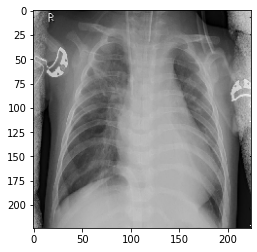

In [ ]:
#Test a sample
trshld = .3 if model_characteristic == 'NP' else .5

print('Labels : ',tst_gens[0].class_indices)
all_img = glob(tst_dir + '/*/*.jpeg')
img_path = random.choice(all_img)
print('\nImage Name : ', img_path.split('/')[-1])

probs = []
for idx, (model, preprocessing_function) in enumerate(zip(models, preprocessing_functions)):
  #if idx <2:
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = target_sizes[idx])  # 讀取影像並resize到網路輸入大小
    img = tf.keras.preprocessing.image.img_to_array(img) #將影像轉為array
    img /= 255.
    plt.imshow(img)
    img *= 255.
    if preprocessing_function:
        img = preprocessing_function(img)
    img /= 255.
    img = np.expand_dims(img, axis=0) 
    print(f'\ninput_name : {input_names[idx]}')
    try:
      p = model.predict(img)
      probs.append(p)
      print(f'({model_names[idx]} predicted probability :{p[0][0]*100:.2f}%)')
    except Exception as e:
      print(type(e).__name__,' : ',str(e))
      print(f'\nThere\'s something wrong with {model_names[idx]}!\n')

mean_prob = np.mean(probs, axis = 0)
predict_result = (np.argmax(mean_prob, axis =1)[0]) if len(model_characteristic) >2 else (1 if mean_prob > trshld else 0)

print(f'\nPrediction : {labels[predict_result]} (confidence : {mean_prob[0][0]*100:.1f} %)')

##Model Testing

In [ ]:
#Checking models
for model, tst_gen, model_name, preprocessing_function, target_size in zip(models, tst_gens, model_names, preprocessing_functions, target_sizes):
  predictions = []
  for i in range(30):
    all_img = glob(tst_dir + '/*/*.jpeg')
    img_path = random.choice(all_img)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = target_size)  # 讀取影像並resize到網路輸入大小
    img = tf.keras.preprocessing.image.img_to_array(img) #將影像轉為array
    if preprocessing_function:
      img = preprocessing_function(img)
    img /= 255.  
    img = np.expand_dims(img, axis=0) 
    predictions.append(labels[1 if model.predict(img)>trshld else 0])

  if len(set(predictions))==1:
    raise ValueError(f'There\'s something wrong with {model_name}')

1/1 [==============================] - 0s 17ms/step


In [ ]:
#Test_result Getting
test_results = []
for idx, (model, tst_gen) in enumerate(zip(models, tst_gens)):
  print(f'\n{model_names[idx]} Testing...')
  test_result = model.evaluate(tst_gen)
  if sum(1 for x in test_result[1:] if x<0.5):
    raise ValueError(f'Theres something wrong with {model_names[idx]}...')
  else:
    print(f'{model_names[idx]} has no problem!')
    test_results.append(test_result)

test_results


ChestX-Ray2BV_23141627_acc92_rec89_prec89.h5 Testing...
390/390 [==============================] - 4s 10ms/step - loss: 0.3192 - accuracy: 0.9231 - recall_1: 0.8986 - precision_1: 0.8986
ChestX-Ray2BV_23141627_acc92_rec89_prec89.h5 has no problem!

ChestX-Ray2BV_23142227_acc91_rec83_prec93.h5 Testing...
390/390 [==============================] - 13s 29ms/step - loss: 0.2632 - accuracy: 0.9077 - recall: 0.8041 - precision: 0.9444
ChestX-Ray2BV_23142227_acc91_rec83_prec93.h5 has no problem!

ChestX-Ray2BV_23152139_acc90_rec85_prec88.h5 Testing...
390/390 [==============================] - 6s 14ms/step - loss: 0.4644 - accuracy: 0.8179 - recall: 0.8243 - precision: 0.7305
ChestX-Ray2BV_23152139_acc90_rec85_prec88.h5 has no problem!

ChestX-Ray2BV_23161132_acc88_rec77_prec91.h5 Testing...
390/390 [==============================] - 4s 10ms/step - loss: 0.3171 - accuracy: 0.8872 - recall: 0.7703 - precision: 0.9194
ChestX-Ray2BV_23161132_acc88_rec77_prec91.h5 has no problem!


[[0.31916800141334534,
  0.9230769276618958,
  0.8986486196517944,
  0.8986486196517944],
 [0.2632215917110443,
  0.9076923131942749,
  0.8040540814399719,
  0.9444444179534912],
 [0.4644032120704651,
  0.8179486989974976,
  0.8243243098258972,
  0.7305389046669006],
 [0.31713876128196716,
  0.8871794939041138,
  0.7702702879905701,
  0.9193548560142517]]

In [ ]:
#Getting Confusion Matrixs
conf_matrixs = []
predict_probs = []

for model, tst_gen in zip(models, tst_gens):
  conf_matrix, predict_prob = get_conf_matrix(
                          model, 
                          tst_dir, 
                          tst_gen.samples, 
                          target_size, 
                          tst_gen, 
                          trshld
                          )
  conf_matrixs.append(conf_matrix)
  predict_probs.append(predict_prob)
  # del model
  # print(f'model_{tst_gens.index(tst_gen)+1} has been deleted.')
  #K.clear_session()  

conf_matrixs

1/1 [==============================] - 0s 30ms/step


[array([[227,  15],
        [ 15, 133]]), array([[235,   7],
        [ 29, 119]]), array([[197,  45],
        [ 26, 122]]), array([[232,  10],
        [ 34, 114]])]



【ChestX-Ray2BV_23141627_acc92_rec89_prec89.h5】
Confusion matrix, without normalization
Accuracy: 92.3 %
Recall: 89.9 %
Precision: 89.9 %
F1 score: 89.9 %


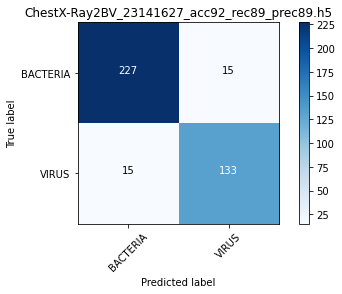



【ChestX-Ray2BV_23142227_acc91_rec83_prec93.h5】
Confusion matrix, without normalization
Accuracy: 90.8 %
Recall: 80.4 %
Precision: 94.4 %
F1 score: 86.9 %


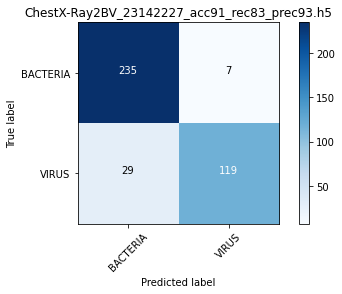



【ChestX-Ray2BV_23152139_acc90_rec85_prec88.h5】
Confusion matrix, without normalization
Accuracy: 81.8 %
Recall: 82.4 %
Precision: 73.1 %
F1 score: 77.5 %


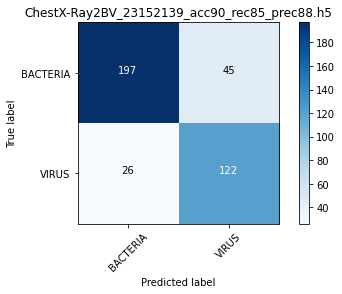



【ChestX-Ray2BV_23161132_acc88_rec77_prec91.h5】
Confusion matrix, without normalization
Accuracy: 88.7 %
Recall: 77.0 %
Precision: 91.9 %
F1 score: 83.8 %


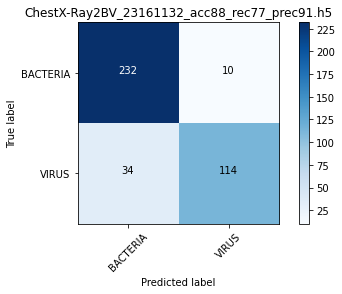

In [ ]:
for conf_matrix, tst_gen, model_name in zip(conf_matrixs, tst_gens, model_names):
  print(f"\n\n【{model_name}】")
  PlotConfusionMatrix(conf_matrix, labels, title = f"{model_name}")

##Ensembling


In [ ]:
#true_y Setting
true_y = []
for _, y in tst_gens[0]:
  true_y = np.concatenate((true_y, y))
  if len(true_y) >= tst_gens[0].samples:
      break
true_y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

【Ensmeble Result】
Confusion matrix, without normalization
Accuracy: 94.1 %
Recall: 86.5 %
Precision: 97.7 %
F1 score: 91.8 %


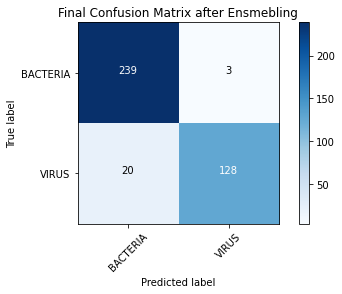

In [ ]:
#Ensemble
trshld = .8
predmean = np.mean(predict_probs, axis=0)
final_prdiction = np.argmax(predmean, axis=1) if model_characteristic == 'NBV' else np.array([[1.] if elem[0] > trshld else [0.] for elem in predmean])
final_confusion_matrix = confusion_matrix(true_y, final_prdiction)
print('【Ensmeble Result】')
PlotConfusionMatrix(final_confusion_matrix, labels, title = f"Final Confusion Matrix after Ensmebling")

##Sample Prediction

Labels :  {'BACTERIA': 0, 'VIRUS': 1}

Image Name :  person50_virus_102.jpeg

input_name : conv2d_3_input
1/1 [==============================] - 0s 18ms/step
time spended : 0.06319 sec
(ChestX-Ray2BV_23141627_acc92_rec89_prec89.h5 predicted probability :87.70%)

input_name : resnet152v2_input
1/1 [==============================] - 0s 32ms/step
time spended : 0.17218 sec
(ChestX-Ray2BV_23142227_acc91_rec83_prec93.h5 predicted probability :91.77%)

input_name : resnet50v2_input
1/1 [==============================] - 0s 24ms/step
time spended : 0.23445 sec
(ChestX-Ray2BV_23152139_acc90_rec85_prec88.h5 predicted probability :84.15%)

input_name : mobilenet_1.00_224_input
1/1 [==============================] - 0s 17ms/step
time spended : 0.29668 sec
(ChestX-Ray2BV_23161132_acc88_rec77_prec91.h5 predicted probability :95.08%)

Prediction : VIRUS (confidence : 89.7 %)


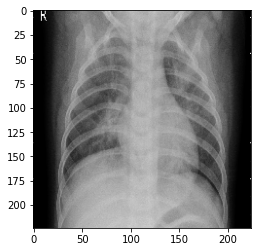

In [ ]:

print('Labels : ',tst_gens[0].class_indices)
all_img = glob(tst_dir + '/*/*.jpeg')
img_path = random.choice(all_img)
print('\nImage Name : ', img_path.split('/')[-1])

probs = []
subtime = time()
for idx, (model, preprocessing_function) in enumerate(zip(models, preprocessing_functions)):
  #if idx <2:
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = target_sizes[idx])  # 讀取影像並resize到網路輸入大小
    img = tf.keras.preprocessing.image.img_to_array(img) #將影像轉為array
    img /= 255.
    plt.imshow(img)
    img *= 255.
    if preprocessing_function:
        img = preprocessing_function(img)
    img /= 255.
    img = np.expand_dims(img, axis=0) 
    print(f'\ninput_name : {input_names[idx]}')
    try:
      p = model.predict(img)
      print(f'time spended : {time()-subtime:.5f} sec')
      probs.append(p)
      print(f'({model_names[idx]} predicted probability :{p[0][0]*100:.2f}%)')
    except Exception as e:
      print(type(e).__name__,' : ',str(e))
      print(f'\nThere\'s something wrong with {model_names[idx]}!\n')

mean_prob = np.mean(probs, axis = 0)
predict_result = (np.argmax(mean_prob, axis =1)[0]) if len(model_characteristic) >2 else (1 if mean_prob > trshld else 0)

print(f'\nPrediction : {labels[predict_result]} (confidence : {mean_prob[0][0]*100:.1f} %)')